<a href="https://colab.research.google.com/github/Priyankavaishnav1006/Stock_Sales_ML_Model/blob/main/Stock_sales_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

file_path= '/content/drive/MyDrive/ML Data 2.csv'
df = pd.read_csv(file_path)

#check 1st five and last five rows
print(df)

#check columns and data type
print(df.info())

          Rows No  Location ID    DealDate Currency Type  Type  Amount  \
0        28937647          140  04/01/2022      JMD    N     S   77000   
1        28937648          140  04/01/2022      XCD    N     S    1000   
2        28937649          140  04/01/2022      KRW    N     S  910000   
3        28937650          140  04/01/2022      EUR    N     S     705   
4        28937651          140  04/01/2022      TRY    N     S    3215   
...           ...          ...         ...      ...  ...   ...     ...   
8234155  46696722           38  30/04/2025      EUR    N     S     335   
8234156  46696723           38  30/04/2025      EUR    N     B     200   
8234157  46696724           38  30/04/2025      EUR    N     S     100   
8234158  46696725           38  30/04/2025      JPY    N     S   27000   
8234159  46696726          272  29/04/2025      EUR    N     S     340   

          Value  OriginationID  OrderTypeID  
0        401.68              2            2  
1        293.17    

# New section

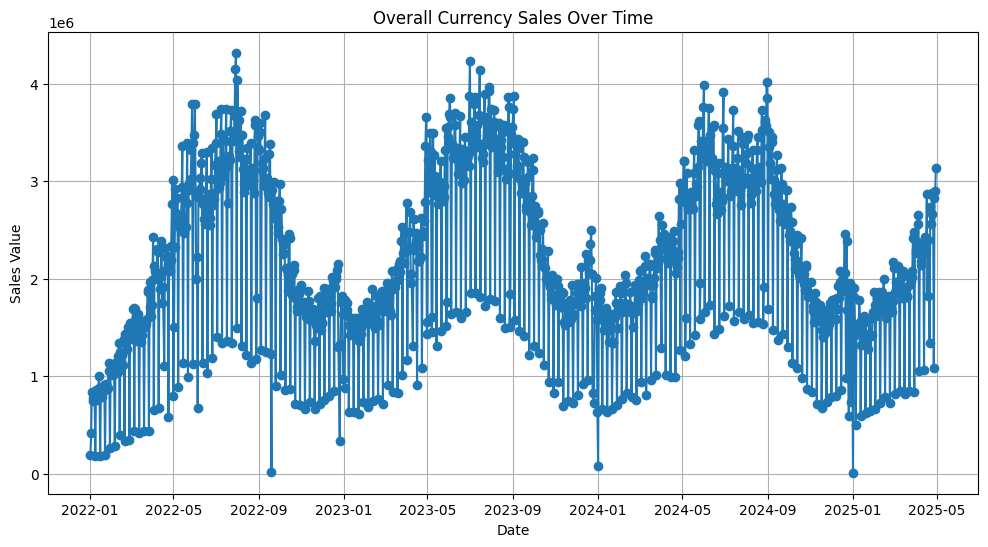

In [12]:
import warnings
warnings.filterwarnings("ignore")   # Ignore warnings

# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns


#convert 'Deal date' to dataframe
#df['DealDate'] = pd.to_datetime(df['DealDate'],dayfirst=True)


#Data Visualization total sales value over time.
#daily_sales = df.groupby('DealDate')['value'].sum().reset_index()

#plt.figure(figsize=(14,6))
#plt.plot(daily_sales['Dealdate'],daily_sales[value],color='blue')
#plt.title('Total sales value over Time')
#plt.xlabel('Date')
#plt.ylabel('Value')
#plt.grid(True)
#plt.show()
# Plot Sales Trend Over Time (All Currencies Combined)
df_grouped = df.groupby('DealDate').agg({'Value': 'sum'}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_grouped['DealDate'], df_grouped['Value'], marker='o')
plt.title('Overall Currency Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.grid()
plt.show()


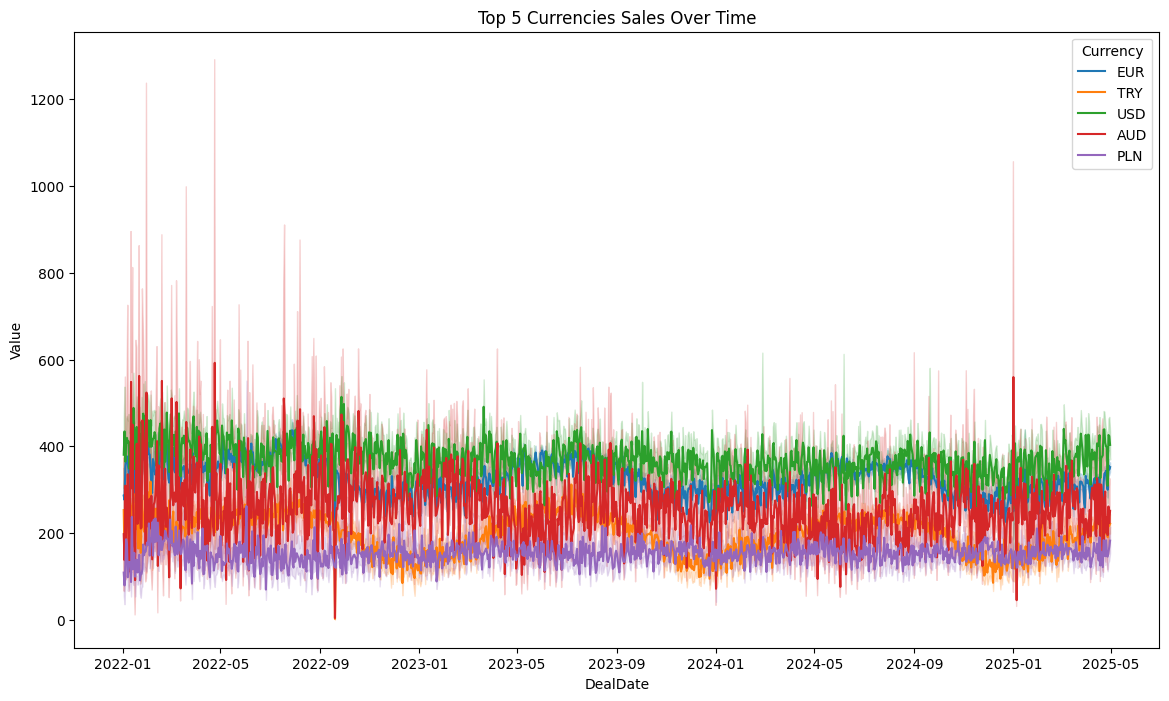

In [13]:
#Sales Trend per Currency (Example: Top 5)
top_currencies = df['Currency'].value_counts().head(5).index
df_top = df[df['Currency'].isin(top_currencies)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_top, x='DealDate', y='Value', hue='Currency')
plt.title('Top 5 Currencies Sales Over Time')
plt.show()